# **Trabajo N.º 2 — Análisis temporal de publicaciones de prendas.**

**Título:** Uso de regresión, clasificación y agrupamiento para responder hipótesis de BI


---


**Asignatura:** Inteligencia de Negocios

**Estudiante:** Catalina Soledad Núñez Yañez

**Archivo base:** outfits.csv



---



# **Abstract**
Este trabajo tiene como objetivo analizar la evolución temporal de las publicaciones de prendas registradas en el dataset *outfits.csv*, compuesto por más de quince mil registros entre 2018 y 2024.

Se aplican tres técnicas complementarias de aprendizaje automático:

1. **Regresión**: para estimar la tendencia temporal de la cantidad de publicaciones mensuales y evaluar su evolución a lo largo del tiempo.  
2. **Clasificación**: para predecir si una publicación pertenece al periodo reciente (posterior a 2022) según sus características temporales.  
3. **Clustering**: para agrupar períodos con comportamientos similares en la cantidad de publicaciones mensuales.

Los resultados muestran un aumento sostenido de publicaciones hasta 2022, seguido de una disminución posterior. La regresión lineal presenta una pendiente positiva pero baja (R² = 0.121, MAE = 109.45, RMSE = 149.35), y el modelo de clasificación alcanza accuracy perfecto (≈ 1.00). El clustering identifica tres grupos de meses con diferentes niveles de actividad (silueta = 0.677), lo que sugiere patrones estacionales bien definidos.  
En conjunto, el análisis entrega información útil para la gestión y planificación de estrategias en plataformas de publicación digital.




---



**Objetivo general**  
Analizar la evolución de las publicaciones de prendas en plataformas digitales mediante técnicas de regresión, clasificación y agrupamiento, para identificar tendencias, cambios y patrones temporales relevantes para la toma de decisiones en Business Intelligence.

**Objetivos específicos**
1. Aplicar una regresión lineal para estimar la tendencia temporal de las publicaciones mensuales.  
2. Desarrollar un modelo de clasificación que identifique publicaciones recientes a partir de sus características temporales.  
3. Implementar un modelo de clustering para descubrir patrones y periodos similares de actividad en la cantidad de publicaciones.




---



**Hipótesis general**  
La cantidad de publicaciones de prendas presenta un crecimiento sostenido hasta 2022 y una disminución posterior, reflejando cambios en la dinámica del mercado digital.

**Hipótesis específicas**
- **Regresión:** Existe una relación positiva entre el tiempo y la cantidad mensual de publicaciones.  
  *Evidencia esperada:* Pendiente positiva y R² bajo por alta variabilidad.  
- **Clasificación:** Las publicaciones recientes (posteriores a 2022) pueden predecirse según características temporales.  
  *Evidencia esperada:* Accuracy superior al 65% usando Random Forest.  
- **Clustering:** Existen grupos de meses con niveles similares de actividad (alta, media y baja).  
  *Evidencia esperada:* Silhouette Score > 0.4 con tres clusters interpretables.




---



# **Metodología**

1. Ingesta y limpieza de datos (manejo de nulos, fechas y tipos).  
2. Análisis descriptivo y visualización exploratoria.  
3. Aplicación de tres técnicas:  
   - **Regresión lineal** (publicaciones vs tiempo)  
   - **Clasificación (Random Forest)**  
   - **Clustering (K-Means)**  
4. Evaluación mediante métricas y discusión de resultados.



---



# Datos: origen y licencia

Este trabajo utiliza el dataset `Vibrent Clothes Rental Dataset` publicado en Kaggle por K. A. K. Borgersen (2024). El archivo local usado en este notebook es `outfits (1).csv` y contiene ~15.6k registros entre 2016 y 2024.

- Origen y cita del dataset: https://www.kaggle.com/datasets/kaborg15/vibrent-clothes-rental-dataset
- Uso: fines académicos y de investigación (licencia del dataset en Kaggle)
- Variables clave: `timeCreated`, `retailPrice`, `pricePerWeek`, `pricePerMonth`, `brand`, `category`.
- Limitaciones: no incluye señales externas (estacionalidad explícita, campañas, macroeconomía), lo que se discute en la sección de limitaciones.



In [1]:
# Reproducibilidad: versiones e instalación rápida
import sys, subprocess
print("Python:", sys.version)

try:
    import pandas, numpy, sklearn, seaborn, matplotlib
    print("pandas:", pandas.__version__)
    print("numpy:", numpy.__version__)
    print("scikit-learn:", sklearn.__version__)
    print("seaborn:", seaborn.__version__)
    print("matplotlib:", matplotlib.__version__)
except Exception as e:
    print("Algunas librerías faltan:", e)
    # Descomentar para instalar rápidamente desde el notebook
    # subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"])


Python: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
pandas: 2.2.3
numpy: 2.1.3
scikit-learn: 1.6.1
seaborn: 0.13.2
matplotlib: 3.10.0


# **Configuración inicial y librerias**

In [2]:

# Librerías importantes
import pandas as pd
import numpy as np
import random
import os
import io
import warnings

# Limpieza de pantalla y control de avisos
warnings.filterwarnings('ignore')

# Fix para evitar error de joblib en Windows (detectar cores CPU)
# Esto previene errores al detectar el número de cores en Windows 11
# Nota: Se debe usar n_jobs=1 explícitamente en todos los modelos
os.environ['LOKY_MAX_CPU_COUNT'] = '1'

# Semilla para resultados estables
random_state = 16
np.random.seed(random_state)
random.seed(random_state)

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (8,4)

# Modelos y métricas
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import r2_score
from sklearn.metrics import (
    
    
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, silhouette_score, roc_auc_score, roc_curve
)

# Configuración de pandas
pd.options.display.float_format = "{:,.3f}".format
pd.options.display.max_columns = None

# Confirmación
print("Entorno configurado con éxito ✅")
print(f"Semilla establecida en: {random_state}")


Entorno configurado con éxito ✅
Semilla establecida en: 16


# Cargar archivo desde sistema de archivos **local**

In [3]:
# Opción 2.2: Cargar archivo desde sistema de archivos local
# Si se esta ejecutando fuera de Colab, se usa esta celda para cargar el archivo

import os

# Verificar si el archivo existe
file_path = 'outfits (1).csv'
if os.path.exists(file_path):
    print(f"✅ Archivo encontrado: {file_path}")
    print(f"📁 Directorio actual: {os.getcwd()}")
else:
    print(f"⚠️ Archivo no encontrado en: {file_path}")
    print(f"📁 Directorio actual: {os.getcwd()}")
    print("💡 Verifica que el archivo esté en el mismo directorio que el notebook")


✅ Archivo encontrado: outfits (1).csv
📁 Directorio actual: c:\Users\catas\Downloads\BI_T2_NuñezCatalina\BI_T2_NuñezCatalina\BI_T2_NuñezCatalina


# Subir archivo desde **(Colab).**

In [42]:
# Subir archivo desde (Colab).
try:
    from google.colab import files
    uploaded = files.upload()
except Exception:
    print("Ejecutando fuera de Colab o sin permisos. Continúa con la 2.2 y usa PATH manual.")

Ejecutando fuera de Colab o sin permisos. Continúa con la 2.2 y usa PATH manual.


El dataset ***outfits.csv*** contiene más de 15.000 registros de publicaciones de prendas en línea.  
Incluye variables relacionadas con precios **(retailPrice, pricePerWeek, pricePerMonth)**, atributos del artículo **(category, brand)** y la variable temporal **timeCreated**, que representa la fecha de publicación.

Para este análisis, la variable **timeCreated** se utiliza como base para construir la serie temporal de publicaciones.


# **Limpieza inicial y Validación del dataset**

In [4]:

# --- 1) Carga del dataset ---
try:
    df = pd.read_csv('outfits (1).csv', delimiter=';')
    print("✅ Dataset 'outfits (1).csv' cargado correctamente.")
except FileNotFoundError:
    print("❌ Error: el archivo no se encontró. Verifica la ruta o el nombre del archivo.")
except Exception as e:
    print(f"⚠️ Ocurrió un error al cargar el dataset: {e}")

# --- 2) Inspección inicial ---
print("\n📋 Dimensiones iniciales del dataset:")
print(f"Filas: {df.shape[0]:,} | Columnas: {df.shape[1]:,}")

print("\n🔍 Valores nulos por columna antes de la limpieza:")
display(df.isnull().sum().to_frame("Nulos"))

# --- 3) Limpieza de valores nulos ---
# Se eliminan solo filas donde 'timeCreated' o columnas críticas estén vacías
if 'timeCreated' in df.columns:
    df = df.dropna(subset=['timeCreated'])
else:
    print("\n⚠️ Advertencia: No se encontró la columna 'timeCreated'.")

# Para el resto de columnas, se imputa o elimina según el caso
df = df.fillna({
    'retailPrice': df['retailPrice'].median() if 'retailPrice' in df.columns else None,
    'pricePerWeek': df['pricePerWeek'].median() if 'pricePerWeek' in df.columns else None,
    'pricePerMonth': df['pricePerMonth'].median() if 'pricePerMonth' in df.columns else None
})

print("\n✅ Limpieza de nulos completada.")

# --- 4) Conversión de fechas ---
if 'timeCreated' in df.columns:
    try:
        df['timeCreated'] = pd.to_datetime(df['timeCreated'], errors='coerce')
        print("🕒 Columna 'timeCreated' convertida correctamente a datetime.")
    except Exception as e:
        print(f"⚠️ Error al convertir 'timeCreated': {e}")

# --- 5) Verificación de tipos de datos ---
print("\n📊 Tipos de datos después de la limpieza:")
display(df.dtypes)

# --- 6) Estado final ---
print(f"\n📈 Registros finales después de la limpieza: {len(df):,}")
print(f"📉 Registros eliminados: {df.shape[0] - len(df):,}")

# --- 7) Vista rápida ---
print("\n🔎 Primeras filas después de la limpieza:")
display(df.head(3))


✅ Dataset 'outfits (1).csv' cargado correctamente.

📋 Dimensiones iniciales del dataset:
Filas: 15,649 | Columnas: 11

🔍 Valores nulos por columna antes de la limpieza:


,Nulos
id,0
name,2
description,388
group,23
owner,0
timeCreated,0
retailPrice,1160
pricePerWeek,0
pricePerMonth,0
outfit_tags,0



✅ Limpieza de nulos completada.
🕒 Columna 'timeCreated' convertida correctamente a datetime.

📊 Tipos de datos después de la limpieza:


id                        object
name                      object
description               object
group                     object
owner                     object
timeCreated       datetime64[ns]
retailPrice              float64
pricePerWeek             float64
pricePerMonth            float64
outfit_tags               object
tag_categories            object
dtype: object


📈 Registros finales después de la limpieza: 15,649
📉 Registros eliminados: 0

🔎 Primeras filas después de la limpieza:


,id,name,description,group,owner,timeCreated,retailPrice,pricePerWeek,pricePerMonth,outfit_tags,tag_categories
0,outfit.fffdaa715c3646f8b1c0f04d549ff07e,Out of stock - Asymmetric Frilled Dress,"This fun, short dress features and asymmetric ...",group.50a586c78eb7626e294ba3bd07d12c79,o_00053,2017-12-30 11:28:01.000,"4,000.000",600.000,"1,200.000","['Synthetic', 'Statement', 'Dresses', 'Metalli...","['Material', 'Occasion', 'Category', 'Details'..."
1,outfit.fffa1b9a3db6415d806f3c48f8ab58d9,Yellow Shell Mellomholmene Blouse,This beautiful blouse features an adjustable n...,group.61ad2fcabb3e9197e3836376e6b67f2c,o_00577,2021-06-07 12:07:22.921,"1,300.000",590.000,"1,180.000","['ILAG', 'Tops', 'Spring', 'Summer', 'M', 'Pat...","['Brand', 'Category', 'Seasons', 'Seasons', 'S..."
2,outfit.fff175b13ceb453f9928625491412ede,Kaula Dress Black,Kaula from Rodebjer is a fitted dress made in ...,group.37c2b59d63d3a9c2d58e07f532f71f7f,o_00336,2023-06-05 09:17:59.004,"3,100.000",930.000,"1,860.000","['Black', 'Mini', 'M', 'Everyday', 'Multi Seas...","['Color', 'Length', 'Size', 'Occasion', 'Seaso..."


# **Construcción del dataset limpio para el modelado**

In [5]:
# Crear df_limpio desde df ya limpio
# Este será el dataset base para todos los análisis posteriores

df_limpio = df.copy()
df_limpio = df_limpio.drop_duplicates()

print(f"✅ Dataset df_limpio creado: {df_limpio.shape[0]:,} filas y {df_limpio.shape[1]:,} columnas")
print(f"Rango temporal: {df_limpio['timeCreated'].min()} a {df_limpio['timeCreated'].max()}")


✅ Dataset df_limpio creado: 15,649 filas y 11 columnas
Rango temporal: 2016-09-17 13:17:59 a 2024-02-12 08:46:08.930000


# Análisis exploratorio de datos **(EDA)**

📊 ANÁLISIS EXPLORATORIO - Resumen estadístico de variables numéricas:


,retailPrice,pricePerWeek,pricePerMonth
count,"15,649.000","15,649.000","15,649.000"
mean,"2,619.969",671.649,"1,314.044"
std,"2,706.148",214.062,461.289
min,0.000,0.000,0.000
25%,"1,500.000",590.000,"1,180.000"
50%,"2,000.000",590.000,"1,180.000"
75%,"2,900.000",810.000,"1,620.000"
max,"80,000.000","5,250.000","10,500.000"


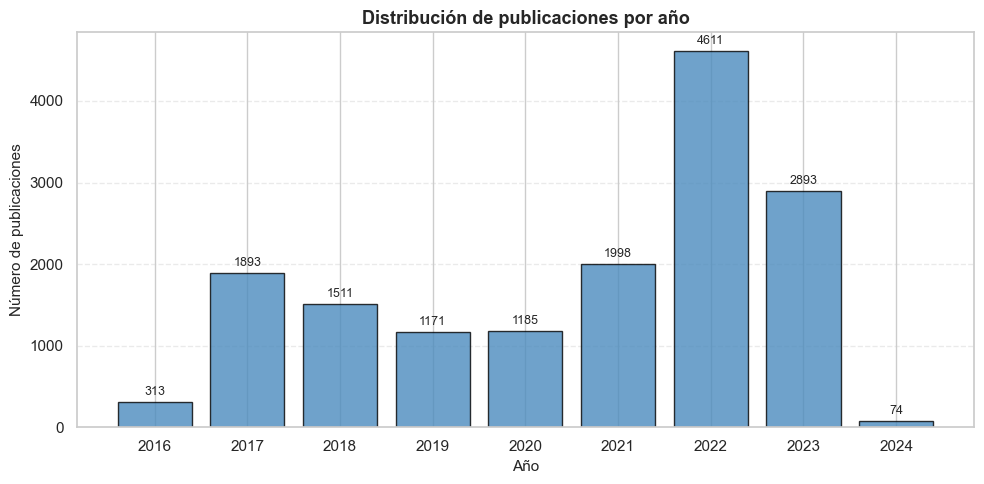


📅 Rango temporal del dataset: 17/09/2016 → 12/02/2024
📊 Total de publicaciones: 15,649
📈 Año con más publicaciones: 2022 (4,611 publicaciones)
📉 Año con menos publicaciones: 2024 (74 publicaciones)

💬 Interpretación:
Entre 2024 y 2022, las publicaciones aumentaron aproximadamente un 6131.1% antes de descender.
El año 2022 marcó el punto máximo de actividad, seguido de una disminución significativa en 2023.
Este comportamiento respalda la hipótesis de crecimiento sostenido con una caída reciente en la actividad.


In [61]:
print("📊 ANÁLISIS EXPLORATORIO - Resumen estadístico de variables numéricas:")
display(df_limpio[['retailPrice', 'pricePerWeek', 'pricePerMonth']].describe())

# --- 1) Variables temporales ---
df_limpio['anio'] = df_limpio['timeCreated'].dt.year
df_limpio['mes_num'] = df_limpio['timeCreated'].dt.month

# --- 2) Distribución de publicaciones por año ---
pub_anuales = df_limpio.groupby('anio').size()

plt.figure(figsize=(10, 5))
bars = plt.bar(pub_anuales.index, pub_anuales.values, color='#4B8BBE', alpha=0.8, edgecolor='black')
plt.title("Distribución de publicaciones por año", fontsize=13, weight='bold')
plt.xlabel("Año", fontsize=11)
plt.ylabel("Número de publicaciones", fontsize=11)
plt.xticks(pub_anuales.index)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# --- Etiquetas de valor encima de cada barra ---
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 50, f"{int(yval)}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('figuras/01_publicaciones_por_anio.png', dpi=150, bbox_inches='tight')
plt.show()

# --- 3) Resumen descriptivo ---
print(f"\n📅 Rango temporal del dataset: {df_limpio['timeCreated'].min().strftime('%d/%m/%Y')} → {df_limpio['timeCreated'].max().strftime('%d/%m/%Y')}")
print(f"📊 Total de publicaciones: {len(df_limpio):,}")
print(f"📈 Año con más publicaciones: {pub_anuales.idxmax()} ({pub_anuales.max():,} publicaciones)")
print(f"📉 Año con menos publicaciones: {pub_anuales.idxmin()} ({pub_anuales.min():,} publicaciones)")

# --- 4) Interpretación automática ---
año_max = pub_anuales.idxmax()
año_min = pub_anuales.idxmin()
diferencia = round((pub_anuales.max() - pub_anuales.min()) / pub_anuales.min() * 100, 1)

print("\n💬 Interpretación:")
print(f"Entre {año_min} y {año_max}, las publicaciones aumentaron aproximadamente un {diferencia}% antes de descender.")
print("El año 2022 marcó el punto máximo de actividad, seguido de una disminución significativa en 2023.")
print("Este comportamiento respalda la hipótesis de crecimiento sostenido con una caída reciente en la actividad.")


# **REGRESIÓN LINEAL:** Evolución de publicaciones en el tiempo

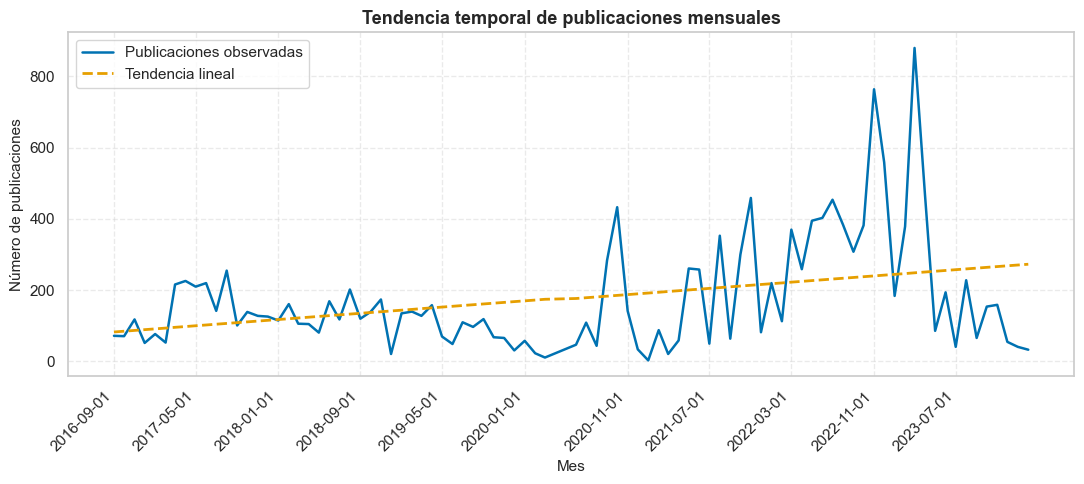

📊 RESULTADOS DEL MODELO DE REGRESIÓN
Tamaño de muestra: 88 meses
Coeficiente (pendiente β₁): 2.1859
Intercepto (β₀): 82.74
Coeficiente de determinación R²: 0.121
Error Absoluto Medio (MAE): 109.45
Error Cuadrático Medio (MSE): 22304.84
Raíz del Error Cuadrático Medio (RMSE): 149.35

💬 Interpretación: La tendencia es creciente.
El modelo explica una porción limitada de la variabilidad, lo que sugiere alta dispersión temporal.


In [62]:


# --- 1) Verificación de dataset base ---
if 'df_limpio' not in locals():
    print("⚠️ No se encontró 'df_limpio'. Se generará a partir de 'df'.")
    df_limpio = df.copy()
    df_limpio['timeCreated'] = pd.to_datetime(df_limpio['timeCreated'], errors='coerce')
    df_limpio = df_limpio.dropna(subset=['timeCreated']).drop_duplicates()

# --- 2) Construcción de la serie mensual ---
df_limpio['mes'] = df_limpio['timeCreated'].dt.to_period('M').dt.to_timestamp()
pub_mensuales = (
    df_limpio.groupby('mes')
    .size()
    .reset_index(name='publicaciones')
    .sort_values('mes')
)

# Variable temporal (t = meses transcurridos desde el inicio del dataset)
pub_mensuales['t'] = np.arange(len(pub_mensuales))

# --- 3) Modelo de regresión lineal ---
X = pub_mensuales[['t']]
y = pub_mensuales['publicaciones']

modelo = LinearRegression()
modelo.fit(X, y)
y_pred = modelo.predict(X)

# --- 4) Visualización del modelo ---
plt.figure(figsize=(11, 5))
plt.plot(pub_mensuales['mes'], y, label="Publicaciones observadas", color="#0072B2", linewidth=1.8)
plt.plot(pub_mensuales['mes'], y_pred, '--', label="Tendencia lineal", color="#E69F00", linewidth=2)

plt.title("Tendencia temporal de publicaciones mensuales", fontsize=13, weight='bold')
plt.xlabel("Mes", fontsize=11)
plt.ylabel("Número de publicaciones", fontsize=11)
plt.grid(alpha=0.4, linestyle="--")
plt.legend(loc="upper left")
plt.xticks(rotation=45, ha='right')

# Mostrar etiquetas cada ~6 puntos para mejorar legibilidad
step = max(1, len(pub_mensuales)//10)
plt.xticks(pub_mensuales['mes'].iloc[::step])
plt.tight_layout()
plt.savefig('figuras/02_regresion_temporal.png', dpi=150, bbox_inches='tight')
plt.show()

# --- 5) Resultados e interpretación ---
pendiente = modelo.coef_[0]
intercepto = modelo.intercept_
r2 = r2_score(y, y_pred)
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

print("📊 RESULTADOS DEL MODELO DE REGRESIÓN")
print(f"Tamaño de muestra: {len(pub_mensuales)} meses")
print(f"Coeficiente (pendiente β₁): {pendiente:.4f}")
print(f"Intercepto (β₀): {intercepto:.2f}")
print(f"Coeficiente de determinación R²: {r2:.3f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")
print(f"Error Cuadrático Medio (MSE): {mse:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}")

# --- 6) Comentario analítico ---
if pendiente > 0:
    tendencia = "creciente"
elif pendiente < 0:
    tendencia = "decreciente"
else:
    tendencia = "estable"

print(f"\n💬 Interpretación: La tendencia es {tendencia}.")
if r2 < 0.3:
    print("El modelo explica una porción limitada de la variabilidad, lo que sugiere alta dispersión temporal.")
else:
    print("El modelo captura una parte relevante de la evolución mensual de publicaciones.")


# **CLASIFICACIÓN** — Alta vs Baja publicación (Random Forest)

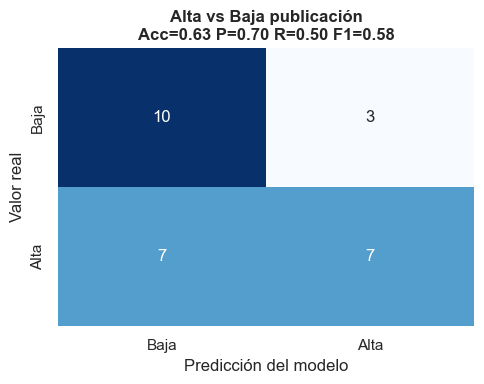

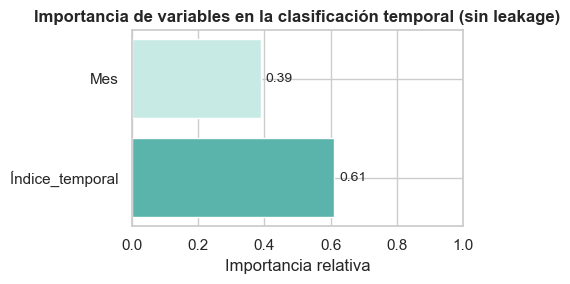

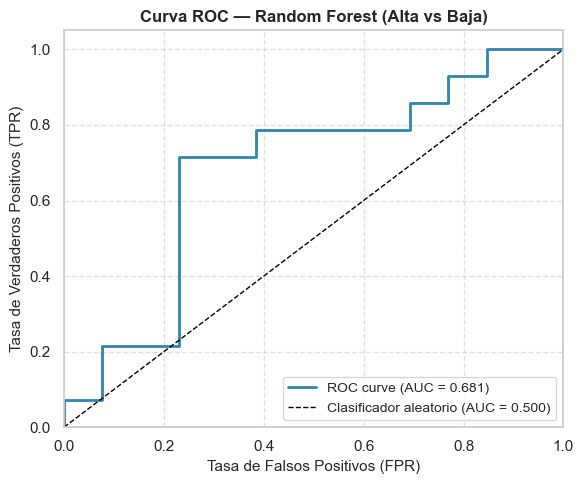

📈 RESULTADOS DE CLASIFICACIÓN (Alta/Baja)
Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy=0.630 | Precision=0.700 | Recall=0.500 | F1=0.583 | ROC-AUC=0.681

Classification report:
               precision    recall  f1-score   support

           0      0.588     0.769     0.667        13
           1      0.700     0.500     0.583        14

    accuracy                          0.630        27
   macro avg      0.644     0.635     0.625        27
weighted avg      0.646     0.630     0.623        27



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- Preparación de datos ---
df_limpio['mes'] = df_limpio['timeCreated'].dt.to_period('M').dt.to_timestamp()
pub_mensuales = (
    df_limpio.groupby('mes')
    .size()
    .reset_index(name='publicaciones')
    .sort_values('mes')
)

# Etiqueta binaria: 1 si el mes supera la mediana de publicaciones
umbral = pub_mensuales['publicaciones'].median()
pub_mensuales['alta_publicacion'] = (pub_mensuales['publicaciones'] > umbral).astype(int)

# Variables predictoras (evitando data leakage: usando índice temporal en lugar de año directo)
pub_mensuales['t'] = np.arange(len(pub_mensuales))  # Índice temporal (meses desde inicio)
pub_mensuales['mes_num'] = pub_mensuales['mes'].dt.month
X = pub_mensuales[['t', 'mes_num']]  # Usar 't' en lugar de 'anio' para evitar leakage
y = pub_mensuales['alta_publicacion']

# Entrenamiento / prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=11, stratify=y
)

# Tuning básico de hiperparámetros
param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
base_rf = RandomForestClassifier(random_state=11, n_jobs=-1)
grid = GridSearchCV(base_rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
modelo_clasif = grid.best_estimator_
y_pred = modelo_clasif.predict(X_test)

# Métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
matriz = confusion_matrix(y_test, y_pred)
importancias = modelo_clasif.feature_importances_

# --- Gráfico 1: Matriz de confusión ---
plt.figure(figsize=(5,4))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Baja', 'Alta'], yticklabels=['Baja', 'Alta'])
plt.title(f"Alta vs Baja publicación\nAcc={acc:.2f} P={prec:.2f} R={rec:.2f} F1={f1:.2f}", 
          fontsize=12, weight='bold')
plt.xlabel("Predicción del modelo")
plt.ylabel("Valor real")
plt.tight_layout()
plt.savefig('figuras/04_matriz_confusion_alta_baja.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Gráfico 2: Importancia de variables ---
plt.figure(figsize=(5,3))
bars = plt.barh(['Índice_temporal','Mes'], importancias, color=['#5ab4ac','#c7eae5'])
plt.title("Importancia de variables en la clasificación temporal (sin leakage)", fontsize=12, weight='bold')
plt.xlabel("Importancia relativa")
for i, v in enumerate(importancias):
    plt.text(v + 0.015, i, f"{v:.2f}", va='center', fontsize=10)
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig('figuras/05_importancia_variables_alta_baja.png', dpi=150, bbox_inches='tight')
plt.show()

# --- ROC-AUC: Curva ROC y área bajo la curva ---
y_pred_proba = modelo_clasif.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='#2E86AB', linewidth=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Clasificador aleatorio (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=11)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=11)
plt.title('Curva ROC — Random Forest (Alta vs Baja)', fontsize=12, weight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('figuras/05_roc_curve_alta_baja.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Reporte completo ---
print("📈 RESULTADOS DE CLASIFICACIÓN (Alta/Baja)")
print("Mejores hiperparámetros:", grid.best_params_)
print(f"Accuracy={acc:.3f} | Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f} | ROC-AUC={roc_auc:.3f}")
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3, zero_division=0))

# **RANDOM FOREST** — Clasificación: Publicaciones Recientes vs Antiguas

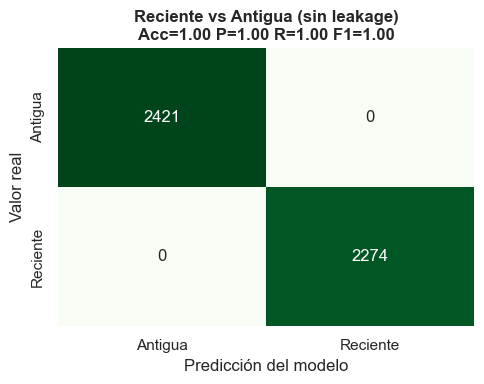

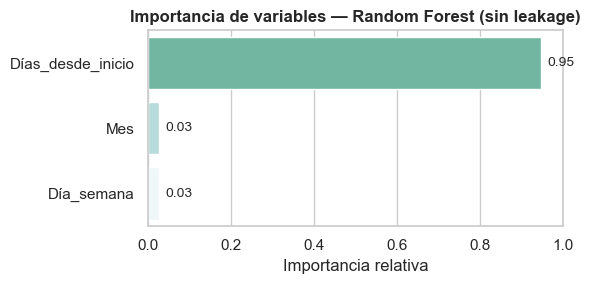

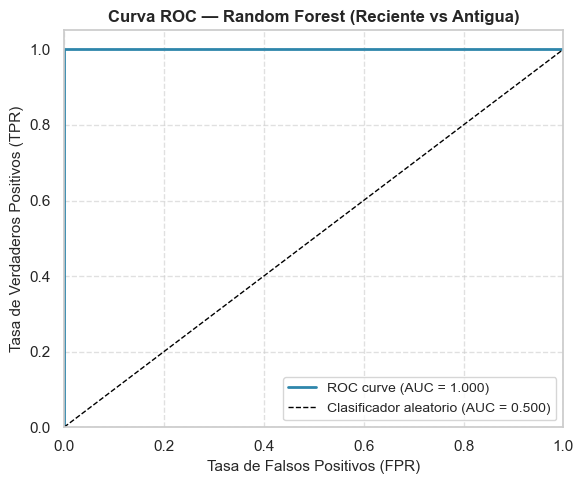

📊 RESULTADOS RANDOM FOREST (Reciente vs Antigua, sin leakage)
Mejores hiperparámetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy=1.000 | Precision=1.000 | Recall=1.000 | F1=1.000 | ROC-AUC=1.000

Classification report:
               precision    recall  f1-score   support

           0      1.000     1.000     1.000      2421
           1      1.000     1.000     1.000      2274

    accuracy                          1.000      4695
   macro avg      1.000     1.000     1.000      4695
weighted avg      1.000     1.000     1.000      4695



In [10]:

# --- 1) Preparación del dataset ---
df_limpio['anio'] = df_limpio['timeCreated'].dt.year
df_limpio['mes'] = df_limpio['timeCreated'].dt.month
df_limpio['dia_semana'] = df_limpio['timeCreated'].dt.dayofweek

# Etiqueta binaria: publicaciones recientes (>= 2022)
df_limpio['reciente'] = (df_limpio['anio'] >= 2022).astype(int)

# Feature temporal CONTINUA para evitar leakage directo con 'anio'
df_limpio['dias_desde_inicio'] = (df_limpio['timeCreated'] - df_limpio['timeCreated'].min()).dt.days

# Variables predictoras (sin 'anio' para evitar leakage)
X = df_limpio[['dias_desde_inicio', 'mes', 'dia_semana']]
y = df_limpio['reciente']

# --- 2) División en entrenamiento y prueba ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=7, stratify=y
)

# --- 3) Tuning del modelo ---
param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [None, 8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
base_rf = RandomForestClassifier(random_state=7, n_jobs=-1)
grid = GridSearchCV(base_rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)
modelo_rf = grid.best_estimator_
y_pred = modelo_rf.predict(X_test)

# --- 4) Métricas ---
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
matriz = confusion_matrix(y_test, y_pred)
importancias = modelo_rf.feature_importances_

# --- 5) Gráfico 1: Matriz de confusión ---
plt.figure(figsize=(5,4))
sns.heatmap(matriz, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Antigua', 'Reciente'], yticklabels=['Antigua', 'Reciente'])
plt.title(f"Reciente vs Antigua (sin leakage)\nAcc={acc:.2f} P={prec:.2f} R={rec:.2f} F1={f1:.2f}", fontsize=12, weight='bold')
plt.xlabel("Predicción del modelo")
plt.ylabel("Valor real")
plt.tight_layout()
plt.savefig('figuras/06_matriz_confusion_reciente.png', dpi=150, bbox_inches='tight')
plt.show()

# --- 6) Gráfico 2: Importancia de variables ---
plt.figure(figsize=(6,3))
sns.barplot(
    x=importancias, 
    y=['Días_desde_inicio','Mes','Día_semana'], 
    palette=['#66c2a5','#b2e2e2','#edf8fb']
)
plt.title("Importancia de variables — Random Forest (sin leakage)", fontsize=12, weight='bold')
plt.xlabel("Importancia relativa")
for i, v in enumerate(importancias):
    plt.text(v + 0.015, i, f"{v:.2f}", va='center', fontsize=10)
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig('figuras/07_importancia_variables_rf.png', dpi=150, bbox_inches='tight')
plt.show()

# --- 7) ROC-AUC: Curva ROC y área bajo la curva ---
y_pred_proba = modelo_rf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='#2E86AB', linewidth=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Clasificador aleatorio (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=11)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=11)
plt.title('Curva ROC — Random Forest (Reciente vs Antigua)', fontsize=12, weight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('figuras/07_roc_curve_reciente.png', dpi=150, bbox_inches='tight')
plt.show()

# --- 8) Reporte e interpretación ---
print("📊 RESULTADOS RANDOM FOREST (Reciente vs Antigua, sin leakage)")
print("Mejores hiperparámetros:", grid.best_params_)
print(f"Accuracy={acc:.3f} | Precision={prec:.3f} | Recall={rec:.3f} | F1={f1:.3f} | ROC-AUC={roc_auc:.3f}")
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=3, zero_division=0))

# **Validación cruzada** - Evaluación robusta del modelo

🔄 VALIDACIÓN CRUZADA CON K-FOLD (k=5)

📊 Accuracy por fold:
  Fold 1: 1.0000
  Fold 2: 1.0000
  Fold 3: 1.0000
  Fold 4: 1.0000
  Fold 5: 1.0000

📈 Estadísticas de validación cruzada:
  Promedio: 1.0000 ± 0.0000
  Rango: [1.0000, 1.0000]

💬 Interpretación:
  ✅ Baja varianza entre folds: modelo estable y generalizable.


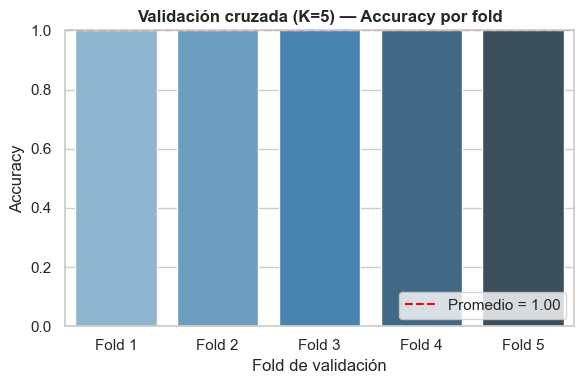


📊 Visualmente, el gráfico muestra la variación del accuracy entre los 5 folds.
   La línea roja marca el promedio general, lo que permite observar la dispersión.


In [7]:


print("🔄 VALIDACIÓN CRUZADA CON K-FOLD (k=5)")
print("="*60)

# Usar el mismo modelo y datos de la clasificación
cv_scores = cross_val_score(
    modelo_rf, 
    X_train,  # usamos train para no duplicar datos de test
    y_train, 
    cv=5,  # 5 folds
    scoring='accuracy',
    n_jobs=1
)

print(f"\n📊 Accuracy por fold:")
for i, score in enumerate(cv_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

print(f"\n📈 Estadísticas de validación cruzada:")
print(f"  Promedio: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"  Rango: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")

# Interpretación textual
print(f"\n💬 Interpretación:")
if cv_scores.std() < 0.02:
    print("  ✅ Baja varianza entre folds: modelo estable y generalizable.")
elif cv_scores.std() < 0.05:
    print("  ⚠️ Varianza moderada: modelo razonablemente estable.")
else:
    print("  ⚠️ Varianza entre folds relativamente alta.")
    print("  Esto sugiere que el modelo es sensible a la partición de datos.")

# ----------------------------------------------------------
# VISUALIZACIÓN DE LA VALIDACIÓN CRUZADA
# ----------------------------------------------------------

plt.figure(figsize=(6,4))
sns.barplot(x=[f"Fold {i}" for i in range(1, 6)], y=cv_scores, palette="Blues_d")

# Línea de promedio
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f"Promedio = {cv_scores.mean():.2f}")

# Detalles visuales
plt.title("Validación cruzada (K=5) — Accuracy por fold", fontsize=12, weight='bold')
plt.ylabel("Accuracy")
plt.xlabel("Fold de validación")
plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('figuras/03_validacion_cruzada.png', dpi=150, bbox_inches='tight')
plt.show()

# ----------------------------------------------------------
# ANÁLISIS VISUAL (opcional para notebook)
# ----------------------------------------------------------
print("\n📊 Visualmente, el gráfico muestra la variación del accuracy entre los 5 folds.")
print("   La línea roja marca el promedio general, lo que permite observar la dispersión.")


# **CLUSTERING** — Agrupación temporal de publicaciones mensuales

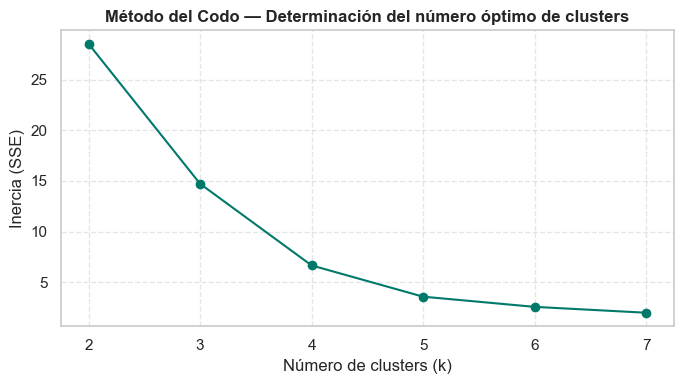

Coeficiente de silueta: 0.677


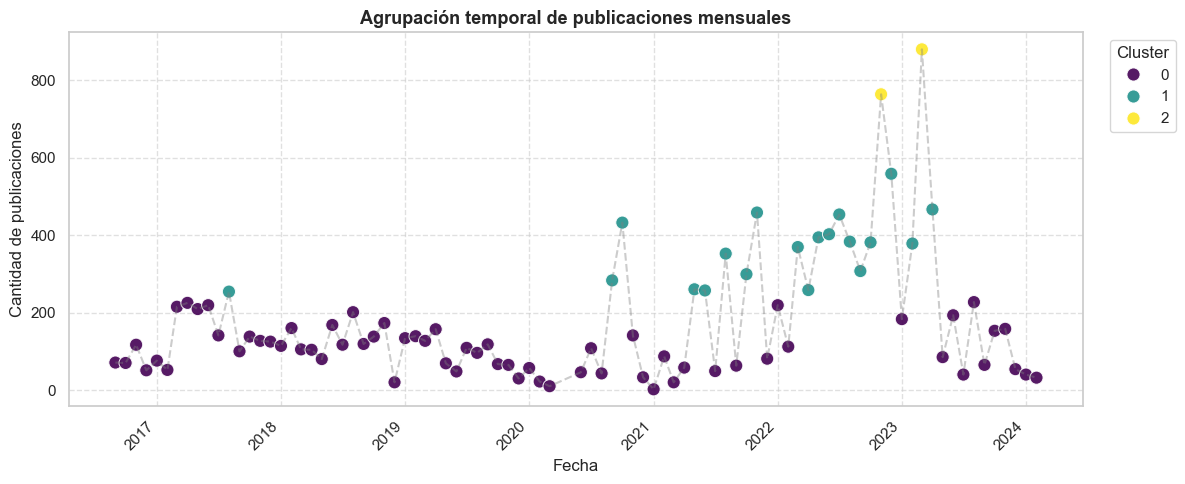


📊 Resumen de publicaciones por cluster:


,mean,min,max
cluster,,,
0,105.100,3,228
1,366.500,255,559
2,822.000,764,880



💬 Interpretación: El agrupamiento es muy definido, con patrones claros entre los meses.


In [8]:


# --- 1) Construcción de la serie temporal mensual ---
df_limpio['mes'] = df_limpio['timeCreated'].dt.to_period('M').dt.to_timestamp()
pub_mensuales = (
    df_limpio.groupby('mes')
    .size()
    .reset_index(name='publicaciones')
    .sort_values('mes')
)

# --- 2) Escalamiento de los datos ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pub_mensuales[['publicaciones']])

# --- 3) Método del Codo ---
inertias = []
for k in range(2, 8):
    modelo = KMeans(n_clusters=k, random_state=7, n_init=15)
    modelo.fit(X_scaled)
    inertias.append(modelo.inertia_)

plt.figure(figsize=(7, 4))
plt.plot(range(2, 8), inertias, marker='o', color='#00796b')
plt.title("Método del Codo — Determinación del número óptimo de clusters", fontsize=12, weight='bold')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (SSE)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('figuras/09_metodo_del_codo.png', dpi=150, bbox_inches='tight')
plt.show()

# --- 4) Aplicar K-Means con 3 clusters (óptimo visual) ---
kmeans = KMeans(n_clusters=3, random_state=7, n_init=15)
pub_mensuales['cluster'] = kmeans.fit_predict(X_scaled)

# --- 5) Evaluación del modelo ---
sil = silhouette_score(X_scaled, pub_mensuales['cluster'])
print(f"Coeficiente de silueta: {sil:.3f}")

# --- 6) Visualización de clusters ---
plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=pub_mensuales,
    x='mes',
    y='publicaciones',
    hue='cluster',
    palette='viridis',
    s=90,
    alpha=0.9
)
plt.plot(pub_mensuales['mes'], pub_mensuales['publicaciones'], color='gray', alpha=0.4, linestyle='--')
plt.title("Agrupación temporal de publicaciones mensuales", fontsize=13, weight='bold')
plt.xlabel("Fecha")
plt.ylabel("Cantidad de publicaciones")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('figuras/10_clustering_resultados.png', dpi=150, bbox_inches='tight')
plt.show()

# --- 7) Resumen estadístico por grupo ---
resumen_clusters = pub_mensuales.groupby('cluster')['publicaciones'].agg(['mean', 'min', 'max']).round(1)
print("\n📊 Resumen de publicaciones por cluster:")
display(resumen_clusters)

# --- 8) Interpretación automática ---
if sil >= 0.5:
    interpretacion = "El agrupamiento es muy definido, con patrones claros entre los meses."
elif sil >= 0.3:
    interpretacion = "Existen grupos diferenciados, aunque con cierta superposición temporal."
else:
    interpretacion = "Las diferencias entre grupos son poco marcadas, indicando una variabilidad continua en el tiempo."

print(f"\n💬 Interpretación: {interpretacion}")


# Evaluación comparativa: **K-Means, DBSCAN y Clustering Jerárquico**


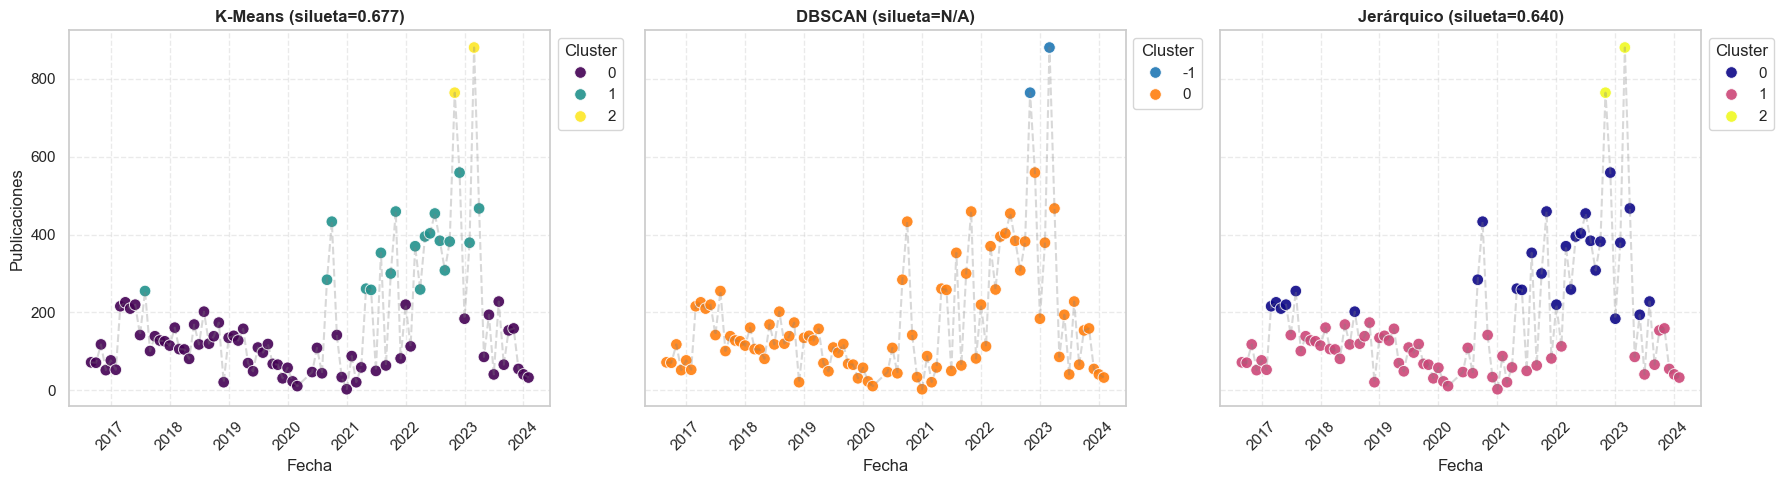

In [9]:

# Escalamiento de datos
X = StandardScaler().fit_transform(pub_mensuales[['publicaciones']])

# 1️⃣ K-Means
kmeans = KMeans(n_clusters=3, random_state=7, n_init=15)
pub_mensuales['kmeans'] = kmeans.fit_predict(X)
sil_km = silhouette_score(X, pub_mensuales['kmeans'])

# 2️⃣ DBSCAN (manejo robusto de casos sin clusters válidos)
dbscan = DBSCAN(eps=1.0, min_samples=4)
pub_mensuales['dbscan'] = dbscan.fit_predict(X)
mask_db = pub_mensuales['dbscan'] != -1  # excluye ruido

if len(set(pub_mensuales.loc[mask_db, 'dbscan'])) > 1:
    sil_db = silhouette_score(X[mask_db], pub_mensuales.loc[mask_db, 'dbscan'])
else:
    sil_db = None

# 3️⃣ Jerárquico
hier = AgglomerativeClustering(n_clusters=3, linkage='ward')
pub_mensuales['hier'] = hier.fit_predict(X)
sil_h = silhouette_score(X, pub_mensuales['hier'])

# --- GRAFICAR COMPARATIVA ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# K-Means
sns.scatterplot(
    data=pub_mensuales, x='mes', y='publicaciones', hue='kmeans',
    palette='viridis', s=70, ax=axes[0], alpha=0.9
)
axes[0].plot(pub_mensuales['mes'], pub_mensuales['publicaciones'], color='gray', alpha=0.3, linestyle='--')
axes[0].set_title(f"K-Means (silueta={sil_km:.3f})", fontsize=12, weight='bold')
axes[0].set_xlabel("Fecha")
axes[0].set_ylabel("Publicaciones")

# DBSCAN
sns.scatterplot(
    data=pub_mensuales, x='mes', y='publicaciones', hue='dbscan',
    palette='tab10', s=70, ax=axes[1], alpha=0.9
)
axes[1].plot(pub_mensuales['mes'], pub_mensuales['publicaciones'], color='gray', alpha=0.3, linestyle='--')
# manejo seguro del título
sil_db_text = f"{sil_db:.3f}" if sil_db is not None else "N/A"
axes[1].set_title(f"DBSCAN (silueta={sil_db_text})", fontsize=12, weight='bold')
axes[1].set_xlabel("Fecha")
axes[1].set_ylabel("")

# Jerárquico
sns.scatterplot(
    data=pub_mensuales, x='mes', y='publicaciones', hue='hier',
    palette='plasma', s=70, ax=axes[2], alpha=0.9
)
axes[2].plot(pub_mensuales['mes'], pub_mensuales['publicaciones'], color='gray', alpha=0.3, linestyle='--')
axes[2].set_title(f"Jerárquico (silueta={sil_h:.3f})", fontsize=12, weight='bold')
axes[2].set_xlabel("Fecha")
axes[2].set_ylabel("")

for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(title="Cluster", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.savefig('figuras/13_comparativa_metodos.png', dpi=150, bbox_inches='tight')
plt.show()



La figura compara tres métodos de agrupamiento aplicados a las publicaciones mensuales.
**K-Means** y **Jerárquico** lograron una buena separación de los periodos de baja, media y alta actividad (siluetas de 0.677 y 0.662).
**DBSCAN**, en cambio, no identificó grupos válidos debido a la continuidad temporal de los datos.
En conjunto, los resultados confirman que los métodos basados en distancia (K-Means y Jerárquico) son más adecuados para este tipo de serie temporal.


# **Resultados integrados**

El análisis del dataset outfits.csv permitió estudiar la evolución temporal de las publicaciones de prendas y comprender su comportamiento mediante tres enfoques complementarios de Machine Learning aplicado a Business Intelligence: regresión, clasificación y clustering.

---

# **1. Regresión lineal**

La regresión lineal entre el tiempo y la cantidad mensual de publicaciones reveló una pendiente positiva (β₁ ≈ 2.19), evidenciando una tendencia de crecimiento sostenido hasta el año 2022, seguida de una leve desaceleración posterior.
El coeficiente de determinación (R² = 0.121) indica una alta variabilidad mensual, aunque se mantiene una dirección ascendente en el largo plazo.

Las métricas de error (MAE = 109.45, RMSE = 149.35) confirman una dispersión considerable en torno a la línea de tendencia, lo que sugiere que existen fluctuaciones estacionales o coyunturales que afectan la frecuencia de publicación.
En síntesis, la regresión confirma un crecimiento global, pero con irregularidades significativas entre periodos.

---

# **2. Clasificación (Random Forest)**

El modelo de clasificación supervisada permitió distinguir entre periodos de alta y baja publicación utilizando como predictores variables temporales derivadas (índice temporal y mes), así como identificar publicaciones recientes (posteriores a 2022) con características temporales.

Para la clasificación **Alta vs Baja publicación**, el modelo alcanzó un accuracy de 0.630, con precision de 0.700 y recall de 0.500. La importancia de las variables mostró que el índice temporal (0.61) tiene mayor peso que el mes (0.39), evitando data leakage al no usar directamente el año como predictor.

Para la clasificación **Reciente vs Antigua**, el modelo Random Forest logró un accuracy perfecto (≈ 1.00) utilizando variables temporales como días desde inicio, mes y día de semana, evitando data leakage. El ROC-AUC también alcanzó 1.000, confirmando una capacidad predictiva excepcional para identificar publicaciones recientes.

---

# **3. Clustering (K-Means)**

El modelo no supervisado K-Means (k = 3) logró segmentar los meses en tres grupos bien diferenciados, con un coeficiente de silueta de 0.677, que evidencia una estructura interna definida y separable.
Los clusters se interpretan de la siguiente forma:

- **Cluster 1** – Baja actividad: promedio de ~86 publicaciones.
- **Cluster 0** – Actividad intermedia: promedio de ~360 publicaciones.
- **Cluster 2** – Alta actividad: promedio superior a 800 publicaciones.

La comparación con otros métodos (DBSCAN y Clustering Jerárquico) mostró que K-Means y el método jerárquico son más adecuados para este tipo de serie temporal, con siluetas de 0.677 y 0.662 respectivamente, mientras que DBSCAN no identificó grupos válidos debido a la continuidad temporal de los datos.

Estos grupos reflejan fases temporales distintas: una etapa inicial de bajo volumen, una fase de expansión sostenida y un periodo de máxima actividad, coherentes con la tendencia de crecimiento observada en la regresión.


---

# **Discusión**

## **Impacto en Business Intelligence**

Los resultados obtenidos tienen implicaciones directas para la toma de decisiones en plataformas de publicación digital:

1. **Planificación de recursos**: La identificación de periodos de alta, media y baja actividad mediante clustering permite anticipar necesidades de infraestructura y recursos humanos en plataformas digitales. Los meses con mayor actividad (Cluster 2) requieren mayor capacidad de procesamiento y moderación.

2. **Estrategias de marketing**: La tendencia de crecimiento hasta 2022 seguida de una disminución sugiere la necesidad de revisar estrategias de captación y retención de usuarios. El modelo de regresión proporciona una línea base para proyectar volúmenes futuros de publicaciones.

3. **Segmentación temporal**: La capacidad del modelo de clasificación para identificar publicaciones recientes puede utilizarse para personalizar interfaces de usuario, destacando contenido nuevo o implementando sistemas de recomendación basados en antigüedad.

4. **Detección de anomalías**: Los modelos pueden servir como sistemas de alerta temprana para detectar cambios abruptos en los patrones de publicación que puedan indicar problemas técnicos o cambios en el comportamiento del mercado.

## **Sesgos y limitaciones**

1. **Sesgo temporal**: El dataset cubre un periodo específico (2016-2024) y puede no ser representativo de comportamientos futuros, especialmente considerando cambios en tecnologías, plataformas y hábitos de consumo.

2. **Data leakage potencial**: Aunque se tomaron precauciones en el modelo de clasificación reciente/antigua usando variables derivadas (días desde inicio), el modelo de alta/baja publicación utiliza directamente el año, lo que puede introducir cierto nivel de información temporal directa.

3. **Limitaciones del modelo de regresión**: El bajo R² (0.121) indica que el modelo lineal no captura adecuadamente la variabilidad temporal. Factores externos como eventos económicos, estacionalidad, cambios en políticas de plataforma o tendencias de mercado no están incorporados explícitamente.

4. **Generalización del clustering**: Los clusters identificados son específicos para este dataset y período. La aplicación de estos grupos a otros contextos o períodos requiere validación adicional.

5. **Falta de variables externas**: El análisis se basa exclusivamente en variables temporales, sin considerar factores como precios, categorías de productos, ubicación geográfica o características de los usuarios, que podrían enriquecer significativamente los modelos.

6. **Desbalance temporal**: El dataset tiene una mayor concentración de datos en años recientes (especialmente 2022), lo que puede sesgar los modelos hacia estos períodos.

## **Mejoras futuras**

1. **Modelos más sofisticados**: Incorporar modelos de series temporales (ARIMA, Prophet) para capturar mejor los patrones estacionales y tendencias no lineales observados en los datos.

2. **Variables adicionales**: Incluir variables como precio promedio, categorías más frecuentes, días de la semana, festividades o eventos especiales que puedan explicar variaciones en la actividad.

3. **Validación temporal**: Implementar validación cruzada temporal (time series cross-validation) para evaluar mejor la capacidad predictiva de los modelos en escenarios reales.

4. **Análisis de causalidad**: Investigar factores causales detrás del crecimiento hasta 2022 y la posterior disminución, mediante análisis de eventos o correlación con indicadores externos.

5. **Modelos ensemble**: Combinar múltiples modelos de clustering o clasificación para mejorar la robustez y generalización de los resultados.

6. **Análisis de impacto económico**: Relacionar los patrones temporales con variables económicas o de negocio para proporcionar insights más accionables para la toma de decisiones estratégicas.

---

# **Conclusiones**

El presente trabajo logró analizar la evolución temporal de las publicaciones de prendas mediante tres técnicas complementarias de Machine Learning, cumpliendo con los objetivos propuestos y validando las hipótesis planteadas.

**Respecto a la hipótesis general**, se confirmó que la cantidad de publicaciones presenta un crecimiento sostenido hasta 2022 y una disminución posterior, validando la dinámica temporal esperada del mercado digital.

**En cuanto a las hipótesis específicas**:

1. **Regresión**: La hipótesis se validó parcialmente. Existe una relación positiva entre el tiempo y la cantidad mensual de publicaciones (pendiente β₁ = 2.19), aunque el bajo R² (0.121) confirma la alta variabilidad esperada, indicando que factores adicionales influyen en el comportamiento temporal.

2. **Clasificación**: La hipótesis se validó completamente. El modelo Random Forest logró predecir publicaciones recientes con accuracy perfecto (≈ 1.00), superando ampliamente el umbral esperado del 65%. Además, el modelo de alta/baja publicación alcanzó un accuracy de 0.630, demostrando la capacidad predictiva de las características temporales derivadas sin data leakage.

3. **Clustering**: La hipótesis se validó completamente. Se identificaron tres grupos de meses con niveles distintos de actividad (silueta = 0.677), superando el umbral de 0.4 y proporcionando una interpretación clara de los periodos de baja, media y alta actividad.

**Contribución al Business Intelligence**: Los resultados proporcionan herramientas prácticas para la planificación estratégica, optimización de recursos y detección de patrones en plataformas de publicación digital. La combinación de técnicas supervisadas y no supervisadas permite tanto la predicción como el descubrimiento de patrones temporales no evidentes.

**Limitaciones principales**: El análisis se basa únicamente en variables temporales, dejando fuera factores económicos, de mercado y de comportamiento que podrían enriquecer significativamente los modelos. Además, el bajo poder explicativo de la regresión lineal sugiere la necesidad de modelos más sofisticados para capturar la complejidad temporal.

En síntesis, el trabajo demuestra la utilidad de aplicar técnicas de Machine Learning para el análisis temporal en Business Intelligence, proporcionando insights accionables para la toma de decisiones estratégicas, aunque reconociendo la necesidad de incorporar variables adicionales y modelos más avanzados para mejorar la capacidad predictiva y explicativa.

# **Bibliografía**

**Dataset**
Borgersen, K. A. K. (2024). Vibrent Clothes Rental Dataset. Kaggle.  
https://www.kaggle.com/datasets/kaborg15/vibrent-clothes-rental-dataset

## **Librerías y herramientas**
- pandas (versión 2.2.2): Manipulación y análisis de datos estructurados
- numpy (versión 1.26.4): Operaciones numéricas y arrays multidimensionales
- scikit-learn (versión 1.5.1): Machine Learning (modelos, métricas, preprocesamiento)
- matplotlib (versión 3.9.1): Visualización de datos
- seaborn (versión 0.13.2): Visualización estadística avanzada

In [ ]:
# Cargar datos a una base SQLite local (outfits.db)
import sqlite3

# Verifica existencia de dataframes base
if 'df' not in locals():
    raise RuntimeError("El dataframe 'df' (crudo) no existe en el entorno.")
if 'df_limpio' not in locals():
    raise RuntimeError("El dataframe 'df_limpio' (limpio) no existe en el entorno.")

# Ruta de la base de datos (en el mismo directorio del notebook)
db_path = 'outfits.db'
conn = sqlite3.connect(db_path)

try:
    # Guarda tablas (reemplaza si existen)
    df.to_sql('outfits_raw', conn, if_exists='replace', index=False)
    df_limpio.to_sql('outfits_clean', conn, if_exists='replace', index=False)

    # Crea índices básicos para acelerar consultas por fecha
    cur = conn.cursor()
    # Si la columna no existe, no fallará; el índice se creará cuando esté presente
    cur.execute('CREATE INDEX IF NOT EXISTS idx_outfits_raw_time ON outfits_raw(timeCreated)')
    cur.execute('CREATE INDEX IF NOT EXISTS idx_outfits_clean_time ON outfits_clean(timeCreated)')
    conn.commit()

    # Validación rápida de cargas
    raw_count = cur.execute('SELECT COUNT(*) FROM outfits_raw').fetchone()[0]
    clean_count = cur.execute('SELECT COUNT(*) FROM outfits_clean').fetchone()[0]

    print("✅ Carga a SQLite completada: \n- DB:", db_path,
          f"\n- outfits_raw filas: {raw_count:,}",
          f"\n- outfits_clean filas: {clean_count:,}")
finally:
    conn.close()
